# Informative Path Planning in a 2D space

This tutorial will walk you through various Informative Path Planning (IPP) scenarios using the `sgptools` library. We'll start with the basic setup and then explore single-robot and multi-robot IPP with different sensor configurations.

## Setup and Imports

We begin by importing the necessary libraries and modules.
- `os`: Used to set environment variables to avoid potential conflicts with underlying libraries.
- `numpy`: For numerical operations.
- `tensorflow`: The backend for GPflow.
- `matplotlib.pyplot`: For plotting the results.
- `sgptools` modules: We import specific classes and functions from the library that we'll be using.


In [ ]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Import necessary components from sgptools
from sgptools.utils.data import Dataset # Class for loading and managing datasets
from sgptools.utils.misc import get_inducing_pts # Utility for selecting inducing points
from sgptools.utils.tsp import run_tsp # TSP/VRP solver for initial path planning
from sgptools.utils.gpflow import get_model_params # For training initial GP/SGP hyperparameters
from sgptools.methods import ContinuousSGP # The main class for continuous SGP optimization
from sgptools.core.transformations import IPPTransform, SquareTransform # Transforms for IPP and sensor models

# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

## Helper Function for Plotting

To keep our main code clean, we define a helper function `plot_paths` to visualize the results of our IPP experiments.

In [ ]:
def plot_paths(paths, dataset, kernel, noise_variance, title, continuous_sening=False, expanded_points=None):
    """
    This function takes the optimized paths and generates a side-by-side comparison of the
    ground truth data field and the reconstruction of that field based on the data
    gathered along the optimized paths.

    Args:
        paths (np.ndarray): The optimized paths for the robots.
        dataset (Dataset): The dataset object containing the ground truth data.
        kernel (gpflow.kernels.Kernel): The GPflow kernel function used for the GP model.
        noise_variance (float): The noise variance of the GP model.
        title (str): The title for the plot.
        continuous_sening (bool): Flag to indicate if the sensor data should be sampled continuously along the path.
        expanded_points (np.ndarray): The expanded points for the sensor's FoV, if applicable.
    """

    # Get sensor data along the optimized paths
    sol_X, sol_y = [], []
    for path in paths:
        X, y = dataset.get_sensor_data(path.reshape(-1, 2), 
                                       continuous_sening=continuous_sening)
        sol_X.extend(X)
        sol_y.extend(y)
    sol_X = np.array(sol_X)
    sol_y = np.array(sol_y)
    
    # Create a GP model to reconstruct the data field from the gathered sensor data
    _, _, _, model = get_model_params(
        sol_X, sol_y, max_steps=0, return_model=True,
        kernel=kernel, 
        noise_variance=noise_variance,
        verbose=False
    )
    X_test, _ = dataset.get_test()
    # Get the  reconstruction
    mean, var = model.predict_f(X_test)
    mean, var = mean.numpy(), var.numpy()

    # ==============================================================================
    # Plotting
    # ==============================================================================

    # Determine the common color scale
    vmin = min(dataset.y.min(), mean.min())
    vmax = max(dataset.y.max(), mean.max())

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # Plot 1: Ground Truth
    im1 = ax1.imshow(dataset.y.T,
                    cmap='jet', origin='lower',
                    extent=[np.min(X_test[:, 0]), np.max(X_test[:, 0]),
                            np.min(X_test[:, 1]), np.max(X_test[:, 1])],
                    vmin=vmin, vmax=vmax)
    ax1.set_title('Ground Truth')
    ax1.set_xlabel('X-coordinate')
    ax1.set_ylabel('Y-coordinate')
    ax1.set_aspect('equal', adjustable='box') # Maintain aspect ratio
    ax1.grid(True)

    # Plot 2: Reconstruction from Solution Path Data
    im2 = ax2.imshow(mean.reshape(dataset.y.shape).T,
                     cmap='jet', origin='lower',
                     extent=[np.min(X_test[:, 0]), np.max(X_test[:, 0]),
                             np.min(X_test[:, 1]), np.max(X_test[:, 1])],
                     vmin=vmin, vmax=vmax)

    colors = ['r', 'g', 'b', 'c', 'm', 'y'] # Colors for different robot paths
    
    # Plot the paths
    for i, path in enumerate(paths):
        ax2.plot(path[:, 0], path[:, 1], 'o-', color=colors[i % len(colors)], label=f'Optimized Path {i+1}')

    # Plot non point FoV if present
    if expanded_points is not None:
        ax2.scatter(expanded_points[:, 0], expanded_points[:, 1], s=10, c='purple', alpha=0.3, label='Expanded FoV Points')

    ax2.set_title('Reconstruction from Solution Path(s) Data')
    ax2.set_xlabel('X-coordinate')
    ax2.set_aspect('equal', adjustable='box') # Maintain aspect ratio
    ax2.grid(True) 
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.suptitle(title)


## Data Loading and Hyperparameter Learning

Before we can start planning paths, we need to:
1.  **Load a dataset**: We'll use the `Dataset` class to generate a synthetic elevation map. This map will serve as the "ground truth" environment that our robot(s) will explore.
2.  **Learn GP hyperparameters**: We'll train a Gaussian Process (GP) model on a small sample of the data to learn the kernel's hyperparameters (like lengthscales and variance). These parameters describe the spatial correlation of the data and are crucial for the SGP-based IPP model.


2025-06-29 16:40:32.666089: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.6951937832093493   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [1.95108 2.15753]    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.0238648349555

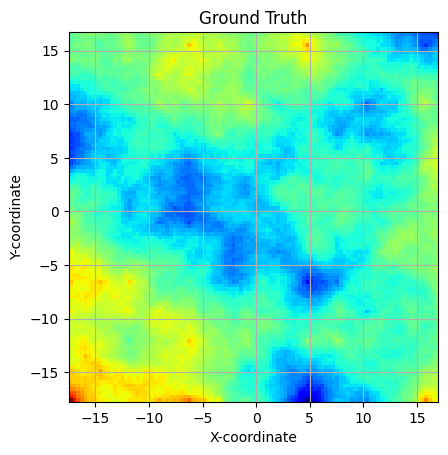

In [3]:
# Get the synthetic elevation data
dataset = Dataset(shape=(100, 100), 
                  num_test=10000, 
                  random_seed=0,
                  verbose=False)
X_train, y_train = dataset.get_train()
X_test, y_test = dataset.get_test()

# Train a Gaussian Process (GP) model and get the optimized kernel parameters
# `get_model_params` returns loss_values, noise_variance, kernel_object
_, noise_variance, kernel = get_model_params(X_train, y_train, 
                                             lengthscales=[1.0, 1.0], # Initial lengthscales for the RBF kernel
                                             optimizer='scipy.L-BFGS-B') # Use SciPy's L-BFGS-B optimizer

# Plot the ground truth data
plt.figure()
im1 = plt.imshow(y_test.reshape(100, 100).T,
                 cmap='jet', origin='lower',
                 extent=[np.min(X_test[:, 0]), np.max(X_test[:, 0]),
                         np.min(X_test[:, 1]), np.max(X_test[:, 1])])
ax1 = plt.gca()
ax1.set_title('Ground Truth')
ax1.set_xlabel('X-coordinate')
ax1.set_ylabel('Y-coordinate')
ax1.set_aspect('equal', adjustable='box')
ax1.grid(True)

## IPP Scenarios
Now we'll explore different IPP scenarios, from simple to more complex.

#### Single-Robot IPP with Point Sensing
This is the most basic scenario. We have a single robot that takes measurements at discrete points (waypoints) along its path.

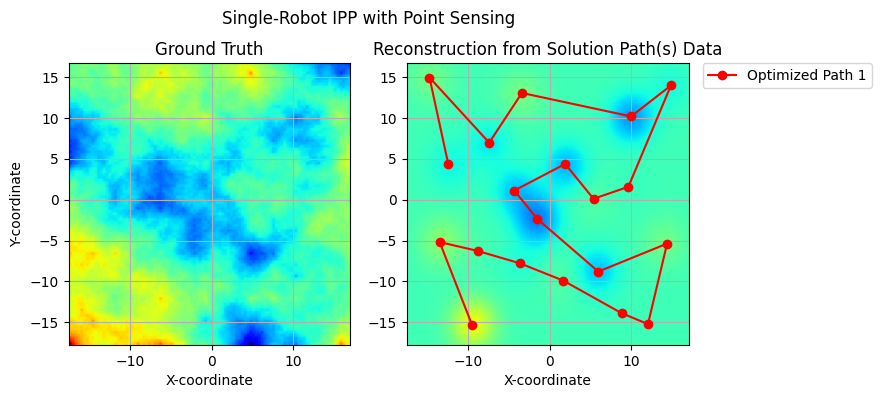

In [4]:
num_robots = 1
num_placements = 20 # Number of sensing locations (waypoints) for the robot

# Initialize the path waypoints using k-means to get a good spatial distribution,
# then run a TSP solver to get a coherent initial path.
Xu_init = get_inducing_pts(X_train, num_placements * num_robots)
Xu_init, _ = run_tsp(Xu_init, num_vehicles=num_robots)
Xu_init = Xu_init[0] # Original shaope (num_robots, num_placements, num_dim)


# Setup the IPP transform for point sensing
# For point sensing, the `sampling_rate` is effectively 2 (the start and end of each path segment).
transform_point_sensing = IPPTransform(num_robots=num_robots)

# Initialize the ContinuousSGP optimizer
csgp_method_point_sensing = ContinuousSGP(
    num_placements, 
    X_train, # X_train serves as the X_objective for the SGP model
    kernel,
    noise_variance, 
    transform_point_sensing,
    num_robots,
    X_init=Xu_init
)

# Optimize the inducing points (path waypoints)
sgp_paths_point_sensing = csgp_method_point_sensing.optimize(max_steps=1000)

# Plot the solution
plot_paths(sgp_paths_point_sensing, dataset, kernel, noise_variance,
           title="Single-Robot IPP with Point Sensing")

#### Single-Robot IPP with Continuous Sensing
Here, we model the robot as sensing *continuously* along its path, not just at the waypoints. We achieve this by setting a `sampling_rate > 2` in the `IPPTransform`, which interpolates points between the waypoints.

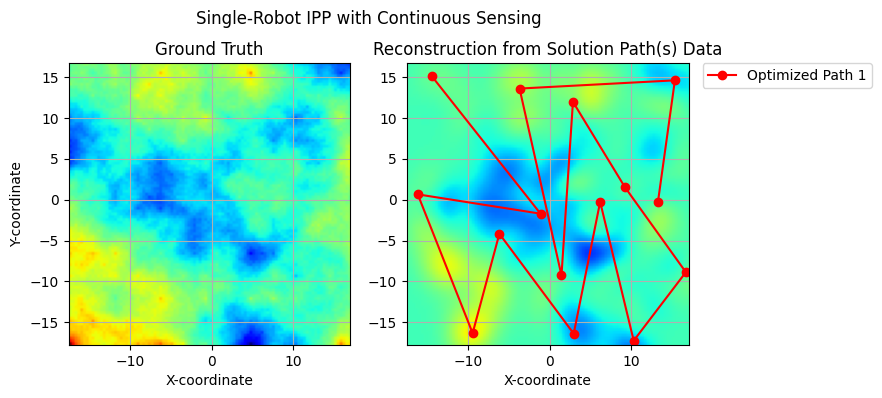

In [5]:
num_robots = 1
num_placements = 15

# Initialize inducing points and get initial path as before
Xu_init_continuous = get_inducing_pts(X_train, num_placements * num_robots)
Xu_init_continuous, _ = run_tsp(Xu_init_continuous, num_vehicles=num_robots)
Xu_init_continuous = Xu_init_continuous[0]

# Setup IPP transform with a higher sampling rate for continuous sensing
transform_continuous_sensing = IPPTransform(num_robots=num_robots,
                                            sampling_rate=5)

# Initialize and optimize the ContinuousSGP model
csgp_method_continuous_sensing = ContinuousSGP(
    num_placements, 
    X_train, 
    kernel,
    noise_variance, 
    transform_continuous_sensing,
    num_robots,
    X_init=Xu_init_continuous
)
sgp_paths_continuous_sensing = csgp_method_continuous_sensing.optimize(max_steps=1000)

# Plot the solution
plot_paths(sgp_paths_continuous_sensing, dataset, kernel, noise_variance,
           title="Single-Robot IPP with Continuous Sensing",
           continuous_sening=True)

####  Single-Robot IPP with a Non-Point FoV Sensor
In this more complex scenario, we model a sensor with a square Field of View (FoV). The `SquareTransform` expands each waypoint (which now includes position and orientation) into a grid of points representing the FoV.

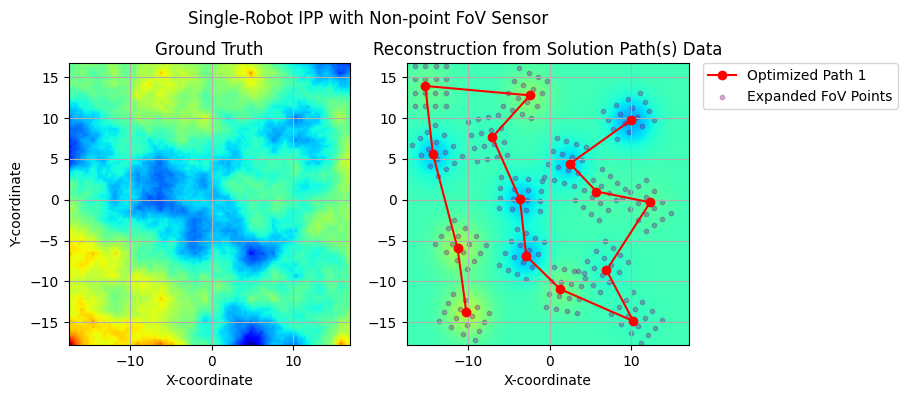

In [6]:
num_robots = 1
num_placements = 15 # Number of sensing locations (waypoints) for the robot

# Initialize inducing points, including an initial random angle for each FoV
Xu_init_fov = get_inducing_pts(X_train, num_placements * num_robots)
Xu_init_fov, _ = run_tsp(Xu_init_fov, num_vehicles=num_robots)
Xu_init_fov = Xu_init_fov[0] # Path for the single robot

# Add random angles (orientation of FoV) to inducing points (waypoints)
# For a 2D position (x, y), we add a 3rd dimension for angle.
angles = np.random.uniform(-np.pi, np.pi, num_placements).reshape(-1, 1)
Xu_init_fov_with_angles = np.concatenate([Xu_init_fov, angles], axis=1)

# Setup a SquareTransform to model a square FoV
# `length` is the side length of the square
# `num_side` is points along each side (3x3 grid for FoV approx)
square_transform = SquareTransform(side_length=5, pts_per_side=4)

# Setup IPP transform with the custom sensor model
# num_dim=3 because the inducing points now have (x, y, angle) dimensions
transform_fov_sensing = IPPTransform(num_robots=num_robots,
                                     num_dim=3, # Input to transform has 3 dimensions (x, y, angle)
                                     sensor_model=square_transform, # The custom FoV model
                                     aggregate_fov=True) # aggregate fov for faster performance

# Initialize and optimize the ContinuousSGP model
# Explicitly mention number of dimensions (x, y, angle) since it is different from X_train dim
csgp_method_fov_sensing = ContinuousSGP(
    num_placements, 
    X_train, 
    kernel,
    noise_variance,
    transform_fov_sensing,
    num_robots,
    X_init=Xu_init_fov_with_angles,
    num_dim=3
)
sgp_sol_sp_fov_sensing = csgp_method_fov_sensing.optimize(max_steps=1000)

# Extract just the (x,y) coordinates of the path for plotting
sgp_paths_fov_sensing = sgp_sol_sp_fov_sensing[:, :, :2].reshape(num_robots, -1 , 2)

# Get the expanded FoV points for visualization
expanded_fov_points = csgp_method_fov_sensing.transform.expand(sgp_sol_sp_fov_sensing).numpy()

# Plot the solution path and the FoVs
plot_paths(sgp_paths_fov_sensing, dataset, kernel, noise_variance,
           title="Single-Robot IPP with Non-point FoV Sensor", 
           expanded_points=expanded_fov_points)

#### Multi-Robot IPP with a Distance Budget
This is a more complex scenario involving multiple robots, each with a limited path length (distance budget). The `IPPTransform` is configured to handle these constraints, and the optimization will try to find the best set of paths that respect the budget.

Distances (Normalized Units): [30.00042943 29.99999999 30.00000204]


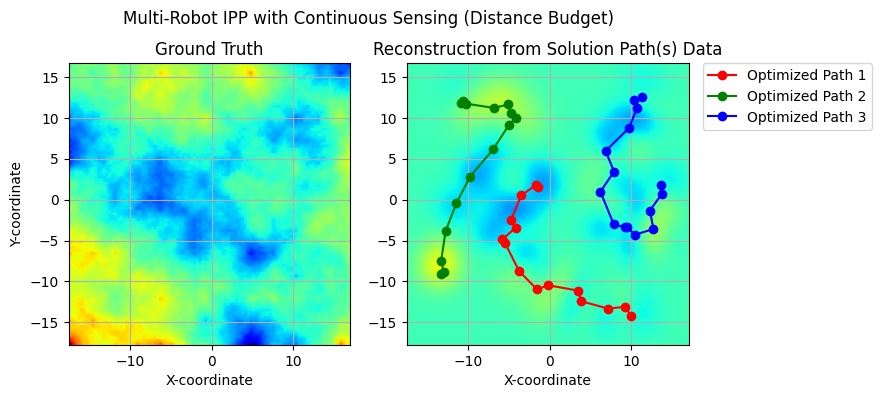

In [7]:
num_robots = 3
num_placements = 15 # Number of sensing locations (waypoints) for each robot

# Initialize inducing points for multiple robots
Xu_init_multi_robot = get_inducing_pts(X_train, num_placements * num_robots)

# Run TSP for multiple vehicles, with a max_dist constraint and resampling
Xu_init_multi_robot, _ = run_tsp(Xu_init_multi_robot, 
                                 num_vehicles=num_robots,
                                 max_dist=100, # Initial max distance budget for TSP
                                 resample=num_placements) # Ensure each path has num_placements waypoints
Xu_init_multi_robot = Xu_init_multi_robot.reshape(-1, 2) # Flatten paths into a single array of waypoints

# Setup distance-constrained IPP transform for multiple robots
transform_multi_robot = IPPTransform(num_robots=num_robots,
                                     sampling_rate=5, # Continuous sensing
                                     distance_budget=30., # Strict distance budget for each robot
                                     constraint_weight=500.) # Weight for the distance constraint in optimization

# Initialize and optimize the ContinuousSGP model for multi-robot scenario
csgp_method_multi_robot = ContinuousSGP(
    num_placements, 
    X_train, 
    kernel,
    noise_variance, 
    transform_multi_robot,
    num_robots,
    X_init=Xu_init_multi_robot
)
sol_paths_multi_robot = csgp_method_multi_robot.optimize(max_steps=5000)

# Plot the optimized paths
plot_paths(sol_paths_multi_robot, dataset, kernel, noise_variance,
           title="Multi-Robot IPP with Continuous Sensing (Distance Budget)",
           continuous_sening=True)

# Print the final distances for each optimized path
# The transform.distance method calculates the total path length based on the current inducing points
print("Distances (Normalized Units):", transform_multi_robot.distance(tf.constant(sol_paths_multi_robot, dtype=tf.float64)).numpy())